In [2]:
import nltk
from importlib.metadata import version
nltk.download('stopwords')
import tensorflow
import summa

import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from bs4 import BeautifulSoup 
from tensorflow.keras.preprocessing.text import Tokenizer 
from tensorflow.keras.preprocessing.sequence import pad_sequences
import urllib.request
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module='bs4')

print('=3')

[nltk_data] Downloading package stopwords to /aiffel/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


=3


##  1. 데이터 수집하기 

In [15]:
import urllib.request
urllib.request.urlretrieve("https://raw.githubusercontent.com/sunnysai12345/News_Summary/master/news_summary_more.csv", filename="news_summary_more.csv")
data = pd.read_csv('news_summary_more.csv', encoding='iso-8859-1')

데이터는 뉴스 기사 데이터(news_summary_more.csv)를 가져왔다..

In [16]:
data.head(10)

,headlines,text
0,upGrad learner switches to career in ML & Al w...,"Saurav Kant, an alumnus of upGrad and IIIT-B's..."
1,Delhi techie wins free food from Swiggy for on...,Kunal Shah's credit card bill payment platform...
2,New Zealand end Rohit Sharma-led India's 12-ma...,New Zealand defeated India by 8 wickets in the...
3,Aegon life iTerm insurance plan helps customer...,"With Aegon Life iTerm Insurance plan, customer..."
4,"Have known Hirani for yrs, what if MeToo claim...",Speaking about the sexual harassment allegatio...
5,Rahat Fateh Ali Khan denies getting notice for...,Pakistani singer Rahat Fateh Ali Khan has deni...
6,"India get all out for 92, their lowest ODI tot...",India recorded their lowest ODI total in New Z...
7,Govt directs Alok Verma to join work 1 day bef...,Weeks after ex-CBI Director Alok Verma told th...
8,Called PM Modi 'sir' 10 times to satisfy his e...,Andhra Pradesh CM N Chandrababu Naidu has said...
9,"Cong wins Ramgarh bypoll in Rajasthan, takes t...",Congress candidate Shafia Zubair won the Ramga...


In [11]:
data = data[['text','headlines']]

In [14]:
data.head(10)

,text,headlines
0,"Saurav Kant, an alumnus of upGrad and IIIT-B's...",upGrad learner switches to career in ML & Al w...
1,Kunal Shah's credit card bill payment platform...,Delhi techie wins free food from Swiggy for on...
2,New Zealand defeated India by 8 wickets in the...,New Zealand end Rohit Sharma-led India's 12-ma...
3,"With Aegon Life iTerm Insurance plan, customer...",Aegon life iTerm insurance plan helps customer...
4,Speaking about the sexual harassment allegatio...,"Have known Hirani for yrs, what if MeToo claim..."
5,Pakistani singer Rahat Fateh Ali Khan has deni...,Rahat Fateh Ali Khan denies getting notice for...
6,India recorded their lowest ODI total in New Z...,"India get all out for 92, their lowest ODI tot..."
7,Weeks after ex-CBI Director Alok Verma told th...,Govt directs Alok Verma to join work 1 day bef...
8,Andhra Pradesh CM N Chandrababu Naidu has said...,Called PM Modi 'sir' 10 times to satisfy his e...
9,Congress candidate Shafia Zubair won the Ramga...,"Cong wins Ramgarh bypoll in Rajasthan, takes t..."


우리는 text를 본문 headline룰 이미 요약된 데이터로 삼아서 모델을 학습할 수 있어요.

##  2. 데이터 전처리하기

### 중복 샘플과 NULL 값이 존재하는 샘플 제거

In [18]:
### 중복  샘플 제거

print('text 열에서 중복을 배제한 유일한 샘플의 수 :', data['text'].nunique())
print('headlines 열에서 중복을 배제한 유일한 샘플의 수 :', data['headlines'].nunique())

text 열에서 중복을 배제한 유일한 샘플의 수 : 98360
headlines 열에서 중복을 배제한 유일한 샘플의 수 : 98280


In [19]:
### null이 존재하는 샘플 값 제거
print(data.isnull().sum())

headlines    0
text         0
dtype: int64


headlines와 text에는 null 값이 존재하지 않는다. 

### 텍스트 정규화와 불용어 제거

기계의 연산량을 줄여주기 위해서 정규화 사전을 이용해서 텍스트 정규화를 해주겠다. 

In [20]:
contractions = {"ain't": "is not", "aren't": "are not","can't": "cannot", "'cause": "because", "could've": "could have", "couldn't": "could not",
                           "didn't": "did not",  "doesn't": "does not", "don't": "do not", "hadn't": "had not", "hasn't": "has not", "haven't": "have not",
                           "he'd": "he would","he'll": "he will", "he's": "he is", "how'd": "how did", "how'd'y": "how do you", "how'll": "how will", "how's": "how is",
                           "I'd": "I would", "I'd've": "I would have", "I'll": "I will", "I'll've": "I will have","I'm": "I am", "I've": "I have", "i'd": "i would",
                           "i'd've": "i would have", "i'll": "i will",  "i'll've": "i will have","i'm": "i am", "i've": "i have", "isn't": "is not", "it'd": "it would",
                           "it'd've": "it would have", "it'll": "it will", "it'll've": "it will have","it's": "it is", "let's": "let us", "ma'am": "madam",
                           "mayn't": "may not", "might've": "might have","mightn't": "might not","mightn't've": "might not have", "must've": "must have",
                           "mustn't": "must not", "mustn't've": "must not have", "needn't": "need not", "needn't've": "need not have","o'clock": "of the clock",
                           "oughtn't": "ought not", "oughtn't've": "ought not have", "shan't": "shall not", "sha'n't": "shall not", "shan't've": "shall not have",
                           "she'd": "she would", "she'd've": "she would have", "she'll": "she will", "she'll've": "she will have", "she's": "she is",
                           "should've": "should have", "shouldn't": "should not", "shouldn't've": "should not have", "so've": "so have","so's": "so as",
                           "this's": "this is","that'd": "that would", "that'd've": "that would have", "that's": "that is", "there'd": "there would",
                           "there'd've": "there would have", "there's": "there is", "here's": "here is","they'd": "they would", "they'd've": "they would have",
                           "they'll": "they will", "they'll've": "they will have", "they're": "they are", "they've": "they have", "to've": "to have",
                           "wasn't": "was not", "we'd": "we would", "we'd've": "we would have", "we'll": "we will", "we'll've": "we will have", "we're": "we are",
                           "we've": "we have", "weren't": "were not", "what'll": "what will", "what'll've": "what will have", "what're": "what are",
                           "what's": "what is", "what've": "what have", "when's": "when is", "when've": "when have", "where'd": "where did", "where's": "where is",
                           "where've": "where have", "who'll": "who will", "who'll've": "who will have", "who's": "who is", "who've": "who have",
                           "why's": "why is", "why've": "why have", "will've": "will have", "won't": "will not", "won't've": "will not have",
                           "would've": "would have", "wouldn't": "would not", "wouldn't've": "would not have", "y'all": "you all",
                           "y'all'd": "you all would","y'all'd've": "you all would have","y'all're": "you all are","y'all've": "you all have",
                           "you'd": "you would", "you'd've": "you would have", "you'll": "you will", "you'll've": "you will have",
                           "you're": "you are", "you've": "you have"}

print("정규화 사전의 수: ", len(contractions))

정규화 사전의 수:  120


In [21]:
# 불용어 제거

print('불용어 개수 :', len(stopwords.words('english') ))
print(stopwords.words('english'))

불용어 개수 : 179
['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 's

정규화 과정과 불용어 제거 준비가 되었다. 데이터 전처리와 과정에서 함께 수행해 주겠다.

상대적으로 짧은 headlines 요약 데이터에는 불용어 처리를 해주면 너무 짧아지기 때문에 불용어 처리를 해주지 않는 것이 좋아보인다. 

In [24]:
# 데이터 전처리 함수
def preprocess_sentence(sentence, remove_stopwords=True):
    sentence = sentence.lower() # 텍스트 소문자화
    sentence = BeautifulSoup(sentence, "lxml").text # <br />, <a href = ...> 등의 html 태그 제거
    sentence = re.sub(r'\([^)]*\)', '', sentence) # 괄호로 닫힌 문자열 (...) 제거 Ex) my husband (and myself!) for => my husband for
    sentence = re.sub('"','', sentence) # 쌍따옴표 " 제거
    sentence = ' '.join([contractions[t] if t in contractions else t for t in sentence.split(" ")]) # 약어 정규화
    sentence = re.sub(r"'s\b","", sentence) # 소유격 제거. Ex) roland's -> roland
    sentence = re.sub("[^a-zA-Z]", " ", sentence) # 영어 외 문자(숫자, 특수문자 등) 공백으로 변환
    sentence = re.sub('[m]{2,}', 'mm', sentence) # m이 3개 이상이면 2개로 변경. Ex) ummmmmmm yeah -> umm yeah
    
    # 불용어 제거 (text)
    if remove_stopwords:
        tokens = ' '.join(word for word in sentence.split() if not word in stopwords.words('english') if len(word) > 1)
    # 불용어 미제거 (headlines)
    else:
        tokens = ' '.join(word for word in sentence.split() if len(word) > 1)
    return tokens
print('=3')

=3


전처리 전, 후의 결과를 확인하기 위해서 임의의 text와 headlines를 만들어 함수를 호출해본다.

In [25]:
temp_text = 'Everything I bought was great, infact I ordered twice and the third ordered was<br />for my mother and father.'
temp_summary = 'Great way to start (or finish) the day!!!'

print("text: ", preprocess_sentence(temp_text))
print("headlines:", preprocess_sentence(temp_summary, False))  # 불용어를 제거하지 않습니다.

text:  everything bought great infact ordered twice third ordered wasfor mother father
headlines: great way to start the day


함수가 잘 작동하는 것을 확인했다. 

이제 함수가 잘 작동하는 것을 확인했으니, 훈련 데이터 전체에 대해서 전처리를 수행할 것이다. 

이때, text의 경우에는 불용어를 제거하고, headlines의 경우에는 불용어를 제거하지 않을 것이므로 따로 호출해서 진행해야 해요. 먼저 text를 전처리하고, 결과를 확인하기 위해서 상위 5개의 줄을 출력 할 것이다. 

In [29]:
clean_text = []
# 전체 Text 데이터에 대한 전처리 : 10분 이상 시간이 걸릴 수 있습니다. 
for s in data['text']:
    clean_text.append(preprocess_sentence(s))

# 전처리 후 출력
print("text 전처리 후 결과: ", clean_text[:5])

text 전처리 후 결과:  ['saurav kant alumnus upgrad iiit pg program machine learning artificial intelligence sr systems engineer infosys almost years work experience program upgrad degree career support helped transition data scientist tech mahindra salary hike upgrad online power learning powered lakh careers', 'kunal shah credit card bill payment platform cred gave users chance win free food swiggy one year pranav kaushik delhi techie bagged reward spending cred coins users get one cred coin per rupee bill paid used avail rewards brands like ixigo bookmyshow ubereats cult fit', 'new zealand defeated india wickets fourth odi hamilton thursday win first match five match odi series india lost international match rohit sharma captaincy consecutive victories dating back march match witnessed india getting seventh lowest total odi cricket history', 'aegon life iterm insurance plan customers enjoy tax benefits premiums paid save taxes plan provides life cover age years also customers options insur

In [31]:
clean_headlines = []
# 전체 Summary 데이터에 대한 전처리 : 5분 이상 시간이 걸릴 수 있습니다. 
for s in data['headlines']:
    clean_headlines.append(preprocess_sentence(s, False))

print("headlines 전처리 후 결과: ", clean_headlines[:5])

headlines 전처리 후 결과:  ['upgrad learner switches to career in ml al with salary hike', 'delhi techie wins free food from swiggy for one year on cred', 'new zealand end rohit sharma led india match winning streak', 'aegon life iterm insurance plan helps customers save tax', 'have known hirani for yrs what if metoo claims are not true sonam']


보다 쉽게 확인하기 위해 데이터들을 데이터프레임에 재저장 하겠다.<br>
빈(empty) 값을 가진 샘플들이 있다면, 모두 Null 값을 가진 샘플로 대체할 것이다.

In [32]:
data['text'] = clean_text
data['headlines'] = clean_headlines

# 빈 값을 Null 값으로 변환
data.replace('', np.nan, inplace=True)

이전과 같이 .isnull().sum()을 사용해서 Null 값이 생겼는지 해볼것이다. 

In [33]:
data.isnull().sum()

headlines    0
text         0
dtype: int64

정제과정에서 null 값이 생기지 않은 것을 확인할 수 있다. 

### 훈련데이터와 테스트데이터 나누기

학습을 진행하기 위해서는 학습에 사용할 데이터의 크기를 결정하고, 문장의 시작과 끝을 표시해 줘야 한다.

### 샘플의 최대 길이 정하기


필요 없는 단어를 모두 솎아낸 데이터를 가지게 되었으니, 이제 훈련에 사용할 샘플의 최대 길이를 정해줄 차례이다.

Text와 Summary의 최소, 최대, 평균 길이를 구하고 또한 길이 분포를 시각화할 것이다.

텍스트의 최소 길이 : 1
텍스트의 최대 길이 : 60
텍스트의 평균 길이 : 35.09983638377659
요약의 최소 길이 : 1
요약의 최대 길이 : 16
요약의 평균 길이 : 9.299651426306644


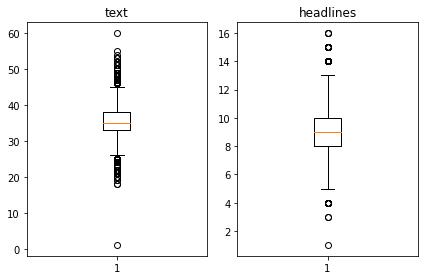

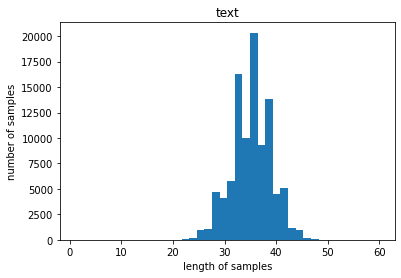

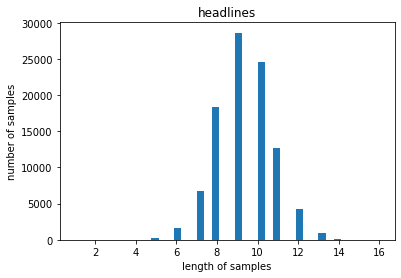

In [36]:
# 길이 분포 출력
import matplotlib.pyplot as plt

text_len = [len(s.split()) for s in data['text']]
headlines_len = [len(s.split()) for s in data['headlines']]

print('텍스트의 최소 길이 : {}'.format(np.min(text_len)))
print('텍스트의 최대 길이 : {}'.format(np.max(text_len)))
print('텍스트의 평균 길이 : {}'.format(np.mean(text_len)))
print('요약의 최소 길이 : {}'.format(np.min(headlines_len)))
print('요약의 최대 길이 : {}'.format(np.max(headlines_len)))
print('요약의 평균 길이 : {}'.format(np.mean(headlines_len)))

plt.subplot(1,2,1)
plt.boxplot(text_len)
plt.title('text')
plt.subplot(1,2,2)
plt.boxplot(headlines_len)
plt.title('headlines')
plt.tight_layout()
plt.show()

plt.title('text')
plt.hist(text_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

plt.title('headlines')
plt.hist(headlines_len, bins = 40)
plt.xlabel('length of samples')
plt.ylabel('number of samples')
plt.show()

위의 그래프처럼, 많은 양의 데이터를 다룰 때는 데이터를 시각화하여 보는 것이 도움이 된다.. 위에서부터 차례대로 그래프는 각각 실제 텍스트와 요약의 길이 분포, 실제 텍스트 샘플 길이별 개수, 요약본 샘플 길이별 개수를 나타내고 있다.

text의 경우 최소 길이가 1, 최대 길이가 60, 평균 길이는 35로 시각화된 그래프로 봤을 때는 대체적으로는 100 내외의 길이를 가진다는 것을 확인할 수 있었다.

headlines의 경우 최소 길이가 1, 최대 길이가 16, 그리고 평균 길이가 9로 Text에 비해 상대적으로 길이가 매우 짧아요. 그래프로 봤을 때에도 대체적으로 10이하의 길이를 가지고 있다.

이로부터 Text의 최대 길이와 headlines의 적절한 최대 길이를 임의로 정해볼 것이다..

In [40]:
text_max_len = 40
headlines_max_len = 12
print('=3')

=3


각각 40과 12로 정했는데 이 길이를 선택했을 때, 얼마나 많은 샘플들을 자르지 않고 포함할 수 있는지 통계로 확인하는 편이 객관적으로 길이를 결정하는 데 도움이 될 것이다. 훈련 데이터와 샘플의 길이를 입력하면, 데이터의 몇 %가 해당하는지 계산하는 함수를 만들어서 좀 더 정확하게 판단해볼 것이다.

In [38]:
def below_threshold_len(max_len, nested_list):
  cnt = 0
  for s in nested_list:
    if(len(s.split()) <= max_len):
        cnt = cnt + 1
  print('전체 샘플 중 길이가 %s 이하인 샘플의 비율: %s'%(max_len, (cnt / len(nested_list))))

이렇게 만든 함수를 text와 headlines에 적용해 우리가 결정한 임의의 길이가 몇%의 샘플까지 포함하는지 볼 수 있을 것이다.

In [41]:
below_threshold_len(text_max_len, data['text'])
below_threshold_len(headlines_max_len,  data['headlines'])

전체 샘플 중 길이가 40 이하인 샘플의 비율: 0.9238320748772878
전체 샘플 중 길이가 12 이하인 샘플의 비율: 0.9880387394437048


각각 40과 12로 패딩을 하게 되면 해당 길이보다 긴 샘플들은 내용이 잘리게 된다.
우리는 정해진 길이에 맞춰 자르는 것이 아니라, 정해진 길이보다 길면 제외하는 방법으로 데이터를 정제할 것이다. 

In [43]:
data = data[data['text'].apply(lambda x: len(x.split()) <= text_max_len)]
data = data[data['headlines'].apply(lambda x: len(x.split()) <= headlines_max_len)]
print('전체 샘플수 :', (len(data)))

전체 샘플수 : 89809


### 시작 토큰과 종료 토큰 추가하기

시작 토큰은 sostoken, 종료 토큰은 eostoken이라 임의로 명명하고 앞, 뒤로 추가할 것이다. 

디코더의 입력에 해당하면서 시작 토큰이 맨 앞에 있는 문장의 이름을 decoder_input, 디코더의 출력 또는 레이블에 해당되면서 종료 토큰이 맨 뒤에 붙는 문장의 이름을 decoder_target이라고 이름을 정했어요. 두 개의 문장 모두 headlines(summary) 열로부터 만들 것이다.

In [45]:
# 요약 데이터에는 시작 토큰과 종료 토큰을 추가한다.
data['decoder_input'] = data['headlines'].apply(lambda x : 'sostoken '+ x)
data['decoder_target'] = data['headlines'].apply(lambda x : x + ' eostoken')
data.head()

,headlines,text,decoder_input,decoder_target
0,upgrad learner switches to career in ml al wit...,saurav kant alumnus upgrad iiit pg program mac...,sostoken upgrad learner switches to career in ...,upgrad learner switches to career in ml al wit...
2,new zealand end rohit sharma led india match w...,new zealand defeated india wickets fourth odi ...,sostoken new zealand end rohit sharma led indi...,new zealand end rohit sharma led india match w...
3,aegon life iterm insurance plan helps customer...,aegon life iterm insurance plan customers enjo...,sostoken aegon life iterm insurance plan helps...,aegon life iterm insurance plan helps customer...
5,rahat fateh ali khan denies getting notice for...,pakistani singer rahat fateh ali khan denied r...,sostoken rahat fateh ali khan denies getting n...,rahat fateh ali khan denies getting notice for...
6,india get all out for their lowest odi total i...,india recorded lowest odi total new zealand ge...,sostoken india get all out for their lowest od...,india get all out for their lowest odi total i...


앞뒤로 토큰이 잘 붙은 것을 확인할 수 있다. 1번은 아마 데이터를 자를때 잘려나간 것 같다.<br>
디코더의 입력과 레이블을 각각 다시 Numpy 타입으로 저장해 줄 것이다 

In [47]:
encoder_input = np.array(data['text']) # 인코더의 입력
decoder_input = np.array(data['decoder_input']) # 디코더의 입력
decoder_target = np.array(data['decoder_target']) # 디코더의 레이블
print('=3')

=3


이제 훈련 데이터와 테스트 데이터를 분리할 것이다.

우선, encoder_input과 크기와 형태가 같은 순서가 섞인 정수 시퀀스를 만들어줄게요.

In [48]:
indices = np.arange(encoder_input.shape[0])
np.random.shuffle(indices)
print(indices)

[46170 45362 18395 ... 27922 47523 42540]


이 정수 시퀀스를 이용해 다시 데이터의 샘플 순서를 정의해 주면 잘 섞인 샘플이 되겠죠.

In [ ]:
encoder_input = encoder_input[indices]
decoder_input = decoder_input[indices]
decoder_target = decoder_target[indices]
print('=3')

이제 섞인 데이터를 8:2의 비율로 훈련 데이터와 테스트 데이터로 분리해 줄게요. 전체 데이터의 크기에서 0.2를 곱해서 테스트 데이터의 크기를 정의해 줄게요.

In [50]:
n_of_val = int(len(encoder_input)*0.2)
print('테스트 데이터의 수 :', n_of_val)

테스트 데이터의 수 : 17961


In [53]:
# -n_of_val을 기준으로 앞에부분은 train 뒷부분은 test로 나눴다.

encoder_input_train = encoder_input[:-n_of_val]
decoder_input_train = decoder_input[:-n_of_val]
decoder_target_train = decoder_target[:-n_of_val]

encoder_input_test = encoder_input[-n_of_val:]
decoder_input_test = decoder_input[-n_of_val:]
decoder_target_test = decoder_target[-n_of_val:]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

훈련 데이터의 개수 : 71848
훈련 레이블의 개수 : 71848
테스트 데이터의 개수 : 17961
테스트 레이블의 개수 : 17961


훈련 데이터와 테스트 데이터가 각각 71848개와 17961개로 잘 분리된 것을 볼 수 있었다.

### 단어 집합(vocabulary) 만들기 및 정수 인코딩

이제 기계가 텍스트를 숫자로 처리할 수 있도록 훈련 데이터와 테스트 데이터의 단어들을 모두 정수로 바꾸어 주어야 한다.

이를 위해서는 각 단어에 고유한 정수를 맵핑하는 작업이 필요하다. 이 과정을 단어 집합(vocabulary) 을 만든다고 표현하는 훈련 데이터에 대해서 단어 집합을 만들어볼 것이다. 

In [55]:
src_tokenizer = Tokenizer() # 토크나이저 정의
src_tokenizer.fit_on_texts(encoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되어 있는데. 현재 생성된 단어 집합은 src_tokenizer.word_index에 저장되어 있어요. 그런데 우리는 이렇게 만든 단어 집합에 있는 모든 단어를 사용하는 것이 아니라, 빈도수가 낮은 단어들은 훈련 데이터에서 제외하고 진행하려고 한다.

등장 빈도수가 7회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인할 것이다.

src_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻을 수 있다.



In [56]:
threshold = 7
total_cnt = len(src_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in src_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 64149
등장 빈도가 6번 이하인 희귀 단어의 수: 43429
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 20720
단어 집합에서 희귀 단어의 비율: 67.70019797658577
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 3.5837981066042226


encoder_input_train에는 6만여 개의 단어가 있네요. 그 아래의 통계 정보들을 해석해보면 등장 빈도가 threshold 값인 7회 미만, 즉 6회 이하인 단어들은 단어 집합에서 무려 67% 이상을 차지하네요. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 적은 수치인 3.58%밖에 되지 않는다.

그래서 등장 빈도가 6회 이하인 단어들은 정수 인코딩 과정에서 빼고, 훈련 데이터에서 제거하고자 합니다. 위에서 이를 제외한 단어 집합의 크기를 20000여 개로 계산했는데, 이와 비슷한 값으로 어림잡아 단어 집합의 크기를 20,000으로 제한해볼 것이다. 토크나이저를 정의할 때 num_words의 값을 정해주면, 단어 집합의 크기를 제한할 수 있다.

In [57]:
src_vocab = 20000
src_tokenizer = Tokenizer(num_words=src_vocab) # 단어 집합의 크기를 20,000으로 제한
src_tokenizer.fit_on_texts(encoder_input_train) # 단어 집합 재생성
print('=3')

=3


texts_to_sequences()는 생성된 단어 집합에 기반하여 입력으로 주어진 텍스트 데이터의 단어들을 모두 정수로 변환하는 정수 인코딩을 수행한다. 현재 단어 집합의 크기를 20,000으로 제한했으니까 이제 20,000이 넘는 숫자들은 정수 인코딩 후에는 데이터에 존재하지 않는다.



In [58]:
# 텍스트 시퀀스를 정수 시퀀스로 변환
encoder_input_train = src_tokenizer.texts_to_sequences(encoder_input_train) 
encoder_input_test = src_tokenizer.texts_to_sequences(encoder_input_test)

# 잘 진행되었는지 샘플 출력
print(encoder_input_train[:3])

[[6460, 8983, 9135, 11303, 9136, 1720, 1791, 2086, 1474, 663, 11304, 1795, 2348, 1338, 849, 22, 137, 1187, 1720, 9135, 2571, 620, 351, 998, 5006, 138, 3553, 2747, 1783, 1478, 2188, 9135, 211, 329, 2086, 2418, 59, 8036], [27, 745, 897, 4, 708, 643, 299, 5203, 70, 241, 10, 86, 91, 86, 299, 168, 4, 254, 117, 86, 841, 249, 5265, 1339, 6897, 1354, 164, 384, 86, 1654, 4, 466, 2619, 2642, 296, 299, 115, 495], [15586, 139, 16325, 1771, 709, 769, 3742, 320, 2276, 14903, 527, 1492, 2512, 709, 2111, 139, 1041, 430, 22, 6, 769, 3416, 2045, 10192, 7411, 3950, 167, 2216, 7207, 139, 1041, 430, 22]]


이제 더 이상 텍스트 데이터가 아니라 정수가 나오는 것을 확인 할 수 있다. 

headlines 데이터에 대해서도 동일한 작업을 수행할게요. 케라스의 토크나이저를 사용하여 decoder_input_train을 입력으로 전체 단어 집합과 각 단어에 대한 빈도수를 계산할 것이다.


In [59]:
tar_tokenizer = Tokenizer() # 토크나이저 정의
tar_tokenizer.fit_on_texts(decoder_input_train) # 입력된 데이터로부터 단어 집합 생성
print('=3')

=3


이제 단어 집합이 생성되는 동시에 각 단어에 고유한 정수가 부여되었다. 이는 tar_tokenizer.word_index에 저장된다. tar_tokenizer.word_counts.items()에는 단어와 각 단어의 등장 빈도수가 저장돼 있는데, 이를 통해서 통계적인 정보를 얻어서, 등장 빈도수가 6회 미만인 단어들이 이 데이터에서 얼만큼의 비중을 차지하는지 확인해볼 것이다.

In [62]:
threshold = 5
total_cnt = len(tar_tokenizer.word_index) # 단어의 수
rare_cnt = 0 # 등장 빈도수가 threshold보다 작은 단어의 개수를 카운트
total_freq = 0 # 훈련 데이터의 전체 단어 빈도수 총 합
rare_freq = 0 # 등장 빈도수가 threshold보다 작은 단어의 등장 빈도수의 총 합

# 단어와 빈도수의 쌍(pair)을 key와 value로 받는다.
for key, value in tar_tokenizer.word_counts.items():
    total_freq = total_freq + value

    # 단어의 등장 빈도수가 threshold보다 작으면
    if(value < threshold):
        rare_cnt = rare_cnt + 1
        rare_freq = rare_freq + value

print('단어 집합(vocabulary)의 크기 :', total_cnt)
print('등장 빈도가 %s번 이하인 희귀 단어의 수: %s'%(threshold - 1, rare_cnt))
print('단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 %s'%(total_cnt - rare_cnt))
print("단어 집합에서 희귀 단어의 비율:", (rare_cnt / total_cnt)*100)
print("전체 등장 빈도에서 희귀 단어 등장 빈도 비율:", (rare_freq / total_freq)*100)

단어 집합(vocabulary)의 크기 : 28423
등장 빈도가 4번 이하인 희귀 단어의 수: 17450
단어 집합에서 희귀 단어를 제외시킬 경우의 단어 집합의 크기 10973
단어 집합에서 희귀 단어의 비율: 61.39394152622876
전체 등장 빈도에서 희귀 단어 등장 빈도 비율: 4.068323651989894


등장 빈도가 4회 이하인 단어들은 단어 집합에서 약 61%를 차지하고 있다. 하지만 실제로 훈련 데이터에서 등장 빈도로 차지하는 비중은 상대적으로 매우 적은 수치인 4.07%밖에 되지 않으니 아까 했던 것과 동일하게 이 단어들은 모두 제거할 것이다. 어림잡아 10,000을 단어 집합의 크기로 제한할 것이다.

In [63]:
tar_vocab = 10000
tar_tokenizer = Tokenizer(num_words=tar_vocab) 
tar_tokenizer.fit_on_texts(decoder_input_train)
tar_tokenizer.fit_on_texts(decoder_target_train)

# 텍스트 시퀀스를 정수 시퀀스로 변환
decoder_input_train = tar_tokenizer.texts_to_sequences(decoder_input_train) 
decoder_target_train = tar_tokenizer.texts_to_sequences(decoder_target_train)
decoder_input_test = tar_tokenizer.texts_to_sequences(decoder_input_test)
decoder_target_test = tar_tokenizer.texts_to_sequences(decoder_target_test)

# 잘 변환되었는지 확인
print('input')
print('input ',decoder_input_train[:5])
print('target')
print('decoder ',decoder_target_train[:5])

input
input  [[1, 5824, 8311, 9008, 3, 731, 4, 2141, 8, 1062, 1099], [1, 43, 1208, 337, 457, 574, 585, 9, 161, 654, 3105], [1, 7232, 190, 7233, 1947, 491, 1031, 1740, 823, 347], [1, 8312, 9868, 721, 167, 321, 629, 455, 5, 2020, 1827], [1, 9, 72, 99, 53, 5, 211, 2576, 261, 1573, 4, 43, 1208]]
target
decoder  [[5824, 8311, 9008, 3, 731, 4, 2141, 8, 1062, 1099, 2], [43, 1208, 337, 457, 574, 585, 9, 161, 654, 3105, 2], [7232, 190, 7233, 1947, 491, 1031, 1740, 823, 347, 2], [8312, 9868, 721, 167, 321, 629, 455, 5, 2020, 1827, 2], [9, 72, 99, 53, 5, 211, 2576, 261, 1573, 4, 43, 1208, 2]]


정상적으로 정수 인코딩 작업이 끝났어요. 현재 decoder_input_train과 decoder_target_train에는 더 이상 숫자 10,000이 넘는 숫자들은 존재하지 않는다. 그런데 다음 작업인 패딩 하기로 넘어가기 전에 한 가지 점검해야 할 것이 있다.

전체 데이터에서 빈도수가 낮은 단어가 삭제되었다는 것은 빈도수가 낮은 단어만으로 구성되었던 샘플들은 이제 빈(empty) 샘플이 되었을 가능성이 있다. 이 현상은 길이가 상대적으로 길었던 원문(Text)의 경우에는 문제가 별로 없겠지만, 애초에 평균 길이가 9밖에 되지 않았던 요약문(headline)의 경우에는 이 현상이 굉장히 두드러졌을 가능성이 높다.

요약문에서 길이가 0이 된 샘플들의 인덱스를 받아와볼 것이다.. 여기서 주의할 점은 요약문인 decoder_input에는 sostoken 또는 decoder_target에는 eostoken이 추가된 상태이고, 이 두 토큰은 모든 샘플에서 등장하므로 빈도수가 샘플 수와 동일하게 매우 높으므로 단어 집합 제한에도 삭제되지 않다는 것이다. 그래서 이제 길이가 0이 된 요약문의 실제 길이는 1로 나올 텐데. 길이 0이 된 decoder_input에는 sostoken, decoder_target에는 eostoken만 남아 있을 것이기 때문이다.

훈련 데이터와 테스트 데이터에 대해서 요약문의 길이가 1인 경우의 인덱스를 각각 drop_train과 drop_test에 라는 변수에 저장해볼게요. 이 샘플들은 모두 삭제할 것이다.



In [65]:
drop_train = [index for index, sentence in enumerate(decoder_input_train) if len(sentence) == 1]
drop_test = [index for index, sentence in enumerate(decoder_input_test) if len(sentence) == 1]

print('삭제할 훈련 데이터의 개수 :', len(drop_train))
print('삭제할 테스트 데이터의 개수 :', len(drop_test))

encoder_input_train = [sentence for index, sentence in enumerate(encoder_input_train) if index not in drop_train]
decoder_input_train = [sentence for index, sentence in enumerate(decoder_input_train) if index not in drop_train]
decoder_target_train = [sentence for index, sentence in enumerate(decoder_target_train) if index not in drop_train]

encoder_input_test = [sentence for index, sentence in enumerate(encoder_input_test) if index not in drop_test]
decoder_input_test = [sentence for index, sentence in enumerate(decoder_input_test) if index not in drop_test]
decoder_target_test = [sentence for index, sentence in enumerate(decoder_target_test) if index not in drop_test]

print('훈련 데이터의 개수 :', len(encoder_input_train))
print('훈련 레이블의 개수 :', len(decoder_input_train))
print('테스트 데이터의 개수 :', len(encoder_input_test))
print('테스트 레이블의 개수 :', len(decoder_input_test))

삭제할 훈련 데이터의 개수 : 0
삭제할 테스트 데이터의 개수 : 0
훈련 데이터의 개수 : 71848
훈련 레이블의 개수 : 71848
테스트 데이터의 개수 : 17961
테스트 레이블의 개수 : 17961


삭제할 훈련 데이터와 삭제할 테스트 데이터 모두 없는 걸로 나온다. 

### 패딩하기

텍스트 시퀀스를 정수 시퀀스로 변환했다면, 이제 서로 다른 길이의 샘플들을 병렬 처리하기 위해 같은 길이로 맞춰주는 패딩 작업을 해주어야 해야 한다. 아까 정해두었던 최대 길이로 패딩 해 줄 것이다. 최대 길이보다 짧은 데이터들은 뒤의 공간에 숫자 0을 넣어 최대 길이로 길이를 맞춰줄게요.

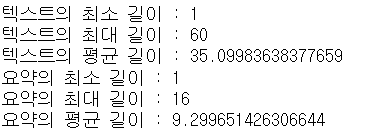

In [68]:
encoder_input_train = pad_sequences(encoder_input_train, maxlen=text_max_len, padding='post')
encoder_input_test = pad_sequences(encoder_input_test, maxlen=text_max_len, padding='post')
decoder_input_train = pad_sequences(decoder_input_train, maxlen=headlines_max_len, padding='post')
decoder_target_train = pad_sequences(decoder_target_train, maxlen=headlines_max_len, padding='post')
decoder_input_test = pad_sequences(decoder_input_test, maxlen=headlines_max_len, padding='post')
decoder_target_test = pad_sequences(decoder_target_test, maxlen=headlines_max_len, padding='post')
print('=3')

=3


이제 학습에 필요한 전처리 과정이 모두 끝났다.

## 3. 어텐션 메커니즘 사용하기 (추상적 요약)

### 모델 설계하기

In [71]:
from tensorflow.keras.layers import Input, LSTM, Embedding, Dense, Concatenate, TimeDistributed
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint


# 인코더 설계 시작
embedding_dim = 128
hidden_size = 256

# 인코더
encoder_inputs = Input(shape=(text_max_len,))

# 인코더의 임베딩 층
enc_emb = Embedding(src_vocab, embedding_dim)(encoder_inputs)

# 인코더의 LSTM 1
# encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4, recurrent_dropout = 0.4)
encoder_lstm1 = LSTM(hidden_size, return_sequences=True, return_state=True ,dropout = 0.4)
encoder_output1, state_h1, state_c1 = encoder_lstm1(enc_emb)

# 인코더의 LSTM 2
# encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm2 = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
encoder_output2, state_h2, state_c2 = encoder_lstm2(encoder_output1)

# 인코더의 LSTM 3
# encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4, recurrent_dropout=0.4)
encoder_lstm3 = LSTM(hidden_size, return_state=True, return_sequences=True, dropout=0.4)
encoder_outputs, state_h, state_c= encoder_lstm3(encoder_output2)

### 디코더를 설계

In [72]:
# 디코더 설계
decoder_inputs = Input(shape=(None,))

# 디코더의 임베딩 층
dec_emb_layer = Embedding(tar_vocab, embedding_dim)
dec_emb = dec_emb_layer(decoder_inputs)

# 디코더의 LSTM
# decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4, recurrent_dropout=0.2)
decoder_lstm = LSTM(hidden_size, return_sequences=True, return_state=True, dropout=0.4)
decoder_outputs, _, _ = decoder_lstm(dec_emb, initial_state=[state_h, state_c])

디코더의 임베딩 층과 LSTM을 설계하는 것은 인코더와 거의 동일하다. 하지만 LSTM의 입력을 정의할 때, initial_state의 인자값으로 인코더의 hidden state와 cell state의 값을 넣어줘야 한다.

디코더의 출력층을 설계해보겠다.

In [73]:
# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_outputs) 

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
______________________________________________________________________________________________

디코더의 출력층에서는 Summary의 단어장인 tar_vocab의 수많은 선택지 중 하나의 단어를 선택하는 다중 클래스 분류 문제를 풀어야 한다. 그렇기 때문에 Dense의 인자로 tar_vocab을 주고, 활성화 함수로 소프트맥스 함수를 사용하고 있다.

지금까지 설계한 것은 인코더의 hidden state와 cell state를 디코더의 초기 state로 사용하는 가장 기본적인 seq2seq이다. 그런데 디코더의 출력층을 설계를 살짝 바꿔서 성능을 높이기 위해서 어텐션 메커니즘을 사용할 것이다. 

### 어텐션 메커니즘

사용하는 어텐션 함수는 Bahdanau 스타일의 어텐션입니다.

아래와 같이 어텐션 층을 만들고, 위에서 설계한 디코더의 출력층을 수정해 봅시다.

In [75]:
from tensorflow.keras.layers import AdditiveAttention

# 어텐션 층(어텐션 함수)
attn_layer = AdditiveAttention(name='attention_layer')

# 인코더와 디코더의 모든 time step의 hidden state를 어텐션 층에 전달하고 결과를 리턴
attn_out = attn_layer([decoder_outputs, encoder_outputs])


# 어텐션의 결과와 디코더의 hidden state들을 연결
decoder_concat_input = Concatenate(axis=-1, name='concat_layer')([decoder_outputs, attn_out])

# 디코더의 출력층
decoder_softmax_layer = Dense(tar_vocab, activation='softmax')
decoder_softmax_outputs = decoder_softmax_layer(decoder_concat_input)

# 모델 정의
model = Model([encoder_inputs, decoder_inputs], decoder_softmax_outputs)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 40)]         0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 40, 128)      2560000     input_1[0][0]                    
__________________________________________________________________________________________________
lstm (LSTM)                     [(None, 40, 256), (N 394240      embedding[0][0]                  
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, None)]       0                                            
____________________________________________________________________________________________

위의 코드는 인코더의 hidden state들과 디코더의 hidden state들을 어텐션 함수의 입력으로 사용하고, 어텐션 함수가 리턴한 값을 예측 시에 디코더의 hidden state와 함께 활용하는 형태로 작동하고 있다.



### 모델 훈련하기

설계한 모델을 가지고 훈련을 진행해볼 것이다.

In [76]:
model.compile(optimizer='rmsprop', loss='sparse_categorical_crossentropy')
es = EarlyStopping(monitor='val_loss', patience=2, verbose=1)
history = model.fit(x=[encoder_input_train, decoder_input_train], y=decoder_target_train, \
          validation_data=([encoder_input_test, decoder_input_test], decoder_target_test), \
          batch_size=256, callbacks=[es], epochs=50)

Epoch 1/50
281/281 [==============================] - 54s 96ms/step - loss: 5.6769 - val_loss: 5.0885
Epoch 2/50
281/281 [==============================] - 26s 93ms/step - loss: 5.0965 - val_loss: 4.7962
Epoch 3/50
281/281 [==============================] - 27s 95ms/step - loss: 4.7576 - val_loss: 4.5487
Epoch 4/50
281/281 [==============================] - 26s 93ms/step - loss: 4.4933 - val_loss: 4.3704
Epoch 5/50
281/281 [==============================] - 26s 93ms/step - loss: 4.2853 - val_loss: 4.2536
Epoch 6/50
281/281 [==============================] - 26s 94ms/step - loss: 4.1129 - val_loss: 4.1634
Epoch 7/50
281/281 [==============================] - 26s 94ms/step - loss: 3.9624 - val_loss: 4.0823
Epoch 8/50
281/281 [==============================] - 26s 94ms/step - loss: 3.8323 - val_loss: 4.0321
Epoch 9/50
281/281 [==============================] - 26s 94ms/step - loss: 3.7159 - val_loss: 3.9780
Epoch 10/50
281/281 [==============================] - 26s 94ms/step - loss: 3.612

'조기 종료'를 뜻하는 EarlyStopping은 특정 조건이 충족되면 훈련을 멈추는 역할을 한다.  
위 코드에서는 val_loss(검증 데이터의 손실)을 관찰하다가, 검증 데이터의 손실이 줄어들지 않고 증가하는 현상이 2회(patience=2) 관측되면 학습을 멈추도록 설정했다. EarlyStopping이 작동한다면 epochs가 아무리 크게 설정되어 있어도 모델 훈련을 최적점에서 멈출 수 있을 것이다.

훈련 데이터의 손실과 검증 데이터의 손실이 줄어드는 과정을 시각화 할 것이다. 

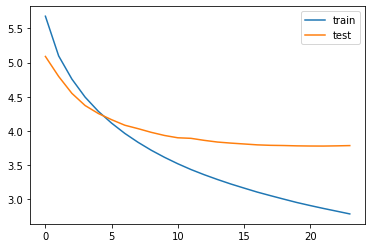

In [77]:
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### 인퍼런스 모델 구현하기

테스트 단계에서는 정수 인덱스 행렬로 존재하던 텍스트 데이터를 실제 데이터로 복원해야 하므로, 필요한 3개의 사전을 아래와 같이 미리 준비해 둡니다.

In [80]:
src_index_to_word = src_tokenizer.index_word # 원문 단어 집합에서 정수 -> 단어를 얻음
tar_word_to_index = tar_tokenizer.word_index # 요약 단어 집합에서 단어 -> 정수를 얻음
tar_index_to_word = tar_tokenizer.index_word # 요약 단어 집합에서 정수 -> 단어를 얻음


seq2seq는 훈련할 때와 실제 동작할 때(인퍼런스 단계)의 방식이 다르므로 그에 맞게 모델 설계를 별개로 진행해야 한다.

훈련 단계에서는 디코더의 입력부에 정답이 되는 문장 전체를 한꺼번에 넣고 디코더의 출력과 한 번에 비교할 수 있으므로, 인코더와 디코더를 엮은 통짜 모델 하나만 준비했습니다.

그러나 정답 문장이 없는 인퍼런스 단계에서는 만들어야 할 문장의 길이만큼 디코더가 반복 구조로 동작해야 하기 때문에 부득이하게 인퍼런스를 위한 모델 설계를 별도로 해주어야 합니다. 이때는 인코더 모델과 디코더 모델을 분리해서 설계합니다.

In [81]:
# 인코더 설계
encoder_model = Model(inputs=encoder_inputs, outputs=[encoder_outputs, state_h, state_c])

# 이전 시점의 상태들을 저장하는 텐서
decoder_state_input_h = Input(shape=(hidden_size,))
decoder_state_input_c = Input(shape=(hidden_size,))

dec_emb2 = dec_emb_layer(decoder_inputs)

# 문장의 다음 단어를 예측하기 위해서 초기 상태(initial_state)를 이전 시점의 상태로 사용. 이는 뒤의 함수 decode_sequence()에 구현
# 훈련 과정에서와 달리 LSTM의 리턴하는 은닉 상태와 셀 상태인 state_h와 state_c를 버리지 않음.
decoder_outputs2, state_h2, state_c2 = decoder_lstm(dec_emb2, initial_state=[decoder_state_input_h, decoder_state_input_c])

print('=3')

=3


어텐션 메커니즘을 사용하는 출력층을 설계

In [82]:
# 어텐션 함수
decoder_hidden_state_input = Input(shape=(text_max_len, hidden_size))
attn_out_inf = attn_layer([decoder_outputs2, decoder_hidden_state_input])
decoder_inf_concat = Concatenate(axis=-1, name='concat')([decoder_outputs2, attn_out_inf])

# 디코더의 출력층
decoder_outputs2 = decoder_softmax_layer(decoder_inf_concat) 

# 최종 디코더 모델
decoder_model = Model(
    [decoder_inputs] + [decoder_hidden_state_input,decoder_state_input_h, decoder_state_input_c],
    [decoder_outputs2] + [state_h2, state_c2])

print('=3')

=3


인퍼런스 단계에서 단어 시퀀스를 완성하는 함수 설계

In [83]:
def decode_sequence(input_seq):
    # 입력으로부터 인코더의 상태를 얻음
    e_out, e_h, e_c = encoder_model.predict(input_seq)

     # <SOS>에 해당하는 토큰 생성
    target_seq = np.zeros((1,1))
    target_seq[0, 0] = tar_word_to_index['sostoken']

    stop_condition = False
    decoded_sentence = ''
    while not stop_condition: # stop_condition이 True가 될 때까지 루프 반복

        output_tokens, h, c = decoder_model.predict([target_seq] + [e_out, e_h, e_c])
        sampled_token_index = np.argmax(output_tokens[0, -1, :])
        sampled_token = tar_index_to_word[sampled_token_index]

        if (sampled_token!='eostoken'):
            decoded_sentence += ' '+sampled_token

        #  <eos>에 도달하거나 최대 길이를 넘으면 중단.
        if (sampled_token == 'eostoken'  or len(decoded_sentence.split()) >= (summary_max_len-1)):
            stop_condition = True

        # 길이가 1인 타겟 시퀀스를 업데이트
        target_seq = np.zeros((1,1))
        target_seq[0, 0] = sampled_token_index

        # 상태를 업데이트 합니다.
        e_h, e_c = h, c

    return decoded_sentence
print('=3')

=3


## 4. 실제 결과와 요약문 비교하기 (추상적 요약)

### 모델 테스트하기

테스트 단계에서는 정수 시퀀스를 텍스트 시퀀스로 변환하여 결과를 확인하는 것이 편할 것이다.. 주어진 정수 시퀀스를 텍스트 시퀀스로 변환하는 함수를 만들겠다. 함수를 만들 때, Text의 정수 시퀀스에서는 패딩을 위해 사용되는 숫자 0을 제외하고 Summary의 정수 시퀀스에서는 숫자 0, 시작 토큰의 인덱스, 종료 토큰의 인덱스를 출력에서 제외하도록 만들 것이다.



In [84]:
# 원문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2text(input_seq):
    temp=''
    for i in input_seq:
        if (i!=0):
            temp = temp + src_index_to_word[i]+' '
    return temp

# 요약문의 정수 시퀀스를 텍스트 시퀀스로 변환
def seq2summary(input_seq):
    temp=''
    for i in input_seq:
        if ((i!=0 and i!=tar_word_to_index['sostoken']) and i!=tar_word_to_index['eostoken']):
            temp = temp + tar_index_to_word[i] + ' '
    return temp

In [85]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("\n")

원문 : residents italy venice protesting mass tourism alleging eroded quality life damaged environment claimed tourism driving away local residents venice current population remains around people leaving year go way venice populated tourists protest organisers said 
실제 요약 : residents in venice protest against tourism 
예측 요약 :  residents escape in up to escape cow on new year


원문 : iran monday denied kuwait expelled ambassador reports emerged gulf country ordered expulsion iranian ambassador diplomats ambassador continue kuwait iranian officials said two countries involved row iran alleged links spy terror cell 
실제 요약 : iranian ambassador to remain in kuwait despite row 
예측 요약 :  iran court orders iran to return to iran


원문 : prolonged drought italy may lead water country faces spring years reports said water supply shutdowns could last long eight hours daily parts country received rainfall totalling normal officials said drought could reportedly lead rome fountains turned 
실제 요약 : ital

예측 요약 :  esha deol shares picture with his mother


원문 : youtube personality dhinchak pooja released new song cash following removal several music videos youtube copyright issues released new song video songs including ka shooter hai mera scooter taken youtube copyright claim someone named singh 
실제 요약 : dhinchak pooja releases new song after copyright row 
예측 요약 :  youtube releases video of new song from youtube


원문 : delhi government monday flagged six mobile vans raise awareness goods services tax address concerns traders regarding new tax regime vans would run different markets across city around days officials would address issues raised traders also take suggestions 
실제 요약 : delhi govt launches gst vans to address traders concerns 
예측 요약 :  delhi govt to buy tax on freecharge for


원문 : south delhi municipal corporation proposed construction six storey parking hold least cars defence colony market solve issue insufficient parking space parking reportedly cost around crore propos

예측 요약 :  was not to be with out of airport twinkle on flight


원문 : actress shabana azmi said filmmakers decide want cut scenes film board added censor board certify films censor scenes however much say cbfc autonomous body people taken board kind ruling party added shabana 
실제 요약 : directors should decide if they want cuts not board azmi 
예측 요약 :  cbfc denies reports of film on film completing housefull


원문 : oldest known world passed away sunday day celebrating th birthday death appeared heartbreaking accident died getting stuck maintenance hatch south florida museum ceo anne said devastated staff volunteers board members considered star added 
실제 요약 : world oldest dies day after th birthday 
예측 요약 :  dies after heart attack on heart dies in accident




기존의 요약과는 다른 요약을 출력하면서도 원문의 내용을 담고 있는 의미 있는 요약들이 보인다. 문법적으로는 조금 어긋낫을 지 모르지만
주요단어들을 잘 잡아내는 것 같다. 하지만 몇개는 요약을 잘 해내지 못하는 거 같기도 하다.

## 5. Summa을 이용해서 추출적 요약해보기

In [102]:
import requests
from summa.summarizer import summarize

In [122]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(seq2text(encoder_input_test[i]).replace(' ','\n'),words = 9).replace('\n', ' ')) #단어수 9개 이하로 출력
     # 공백을 줄바꿈으로 바꿔주고 줄바꿈을 공백으로 되돌려준다.
    print("\n")

원문 : residents italy venice protesting mass tourism alleging eroded quality life damaged environment claimed tourism driving away local residents venice current population remains around people leaving year go way venice populated tourists protest organisers said 
실제 요약 : residents in venice protest against tourism 
예측 요약 : residents italy mass eroded quality driving residents organisers said


원문 : iran monday denied kuwait expelled ambassador reports emerged gulf country ordered expulsion iranian ambassador diplomats ambassador continue kuwait iranian officials said two countries involved row iran alleged links spy terror cell 
실제 요약 : iranian ambassador to remain in kuwait despite row 
예측 요약 : iran denied kuwait emerged diplomats officials iran spy terror


원문 : prolonged drought italy may lead water country faces spring years reports said water supply shutdowns could last long eight hours daily parts country received rainfall totalling normal officials said drought could reportedly

예측 요약 : trailer poster sunny bobby actor shreyas revolves promoting shreyas


원문 : singer sunidhi chauhan said understand songs recreated india despite much talent country added many people waiting get opportunity talented fond sunidhi said original music required else music gets repetitive audiences 
실제 요약 : do not get why we recreate songs despite our talent sunidhi 
예측 요약 : singer sunidhi recreated despite talent waiting talented sunidhi original


원문 : actor amitabh bachchan announced role unicef goodwill ambassador extended two years said owing success polio drive bachchan working spreading awareness regarding vaccination mr infections children 
실제 요약 : bachchan role as unicef ambassador extended for more yrs 
예측 요약 : actor amitabh goodwill extended years said polio spreading mr


원문 : sweety tera drama first song kriti sanon ayushmann khurrana rajkummar rao starrer bareilly ki barfi released composed tanishk bagchi sung dev negi pandey shraddha pandit lyrics ahmed directed ashwin

In [121]:
for i in range(50, 100):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("예측 요약 :", summarize(seq2text(encoder_input_test[i]).replace(' ','\n'),ratio=0.2).replace('\n', ' ')) #원문의 20% 만 출력
    # 공백을 줄바꿈으로 바꿔주고 줄바꿈을 공백으로 되돌려준다. 
    print("\n")

원문 : residents italy venice protesting mass tourism alleging eroded quality life damaged environment claimed tourism driving away local residents venice current population remains around people leaving year go way venice populated tourists protest organisers said 
실제 요약 : residents in venice protest against tourism 
예측 요약 : residents italy mass residents organisers said


원문 : iran monday denied kuwait expelled ambassador reports emerged gulf country ordered expulsion iranian ambassador diplomats ambassador continue kuwait iranian officials said two countries involved row iran alleged links spy terror cell 
실제 요약 : iranian ambassador to remain in kuwait despite row 
예측 요약 : iran denied emerged iran spy terror


원문 : prolonged drought italy may lead water country faces spring years reports said water supply shutdowns could last long eight hours daily parts country received rainfall totalling normal officials said drought could reportedly lead rome fountains turned 
실제 요약 : italy may fac



원문 : sweety tera drama first song kriti sanon ayushmann khurrana rajkummar rao starrer bareilly ki barfi released composed tanishk bagchi sung dev negi pandey shraddha pandit lyrics ahmed directed ashwiny iyer tiwari film scheduled release august 
실제 요약 : bareilly ki barfi first song drama released 
예측 요약 : sweety tera song bagchi film scheduled


원문 : british cyclist chris third consecutive fourth overall tour de france finishing race hours minutes seconds paris sunday year old rider finished event second lead moved within one win time record km day long grand tour featured total riders 
실제 요약 : wins th tour de france finishes race in under hrs 
예측 요약 : british chris consecutive seconds sunday second


원문 : man arrested london airport allegedly tried open plane door air flight man walked front plane sat next woman emergency exit wing suddenly across open door restrained crew flight 
실제 요약 : passenger arrested after trying to open plane door mid air 
예측 요약 : man airport allegedly man

In [125]:
for i in range(50, 52):
    print("원문 :", seq2text(encoder_input_test[i]))
    print("실제 요약 :", seq2summary(decoder_input_test[i]))
    print("abstract예측 요약 :", decode_sequence(encoder_input_test[i].reshape(1, text_max_len)))
    print("summa예측 요약1 :", summarize(seq2text(encoder_input_test[i]).replace(' ','\n'),words = 9).replace('\n', ' ')) #단어수 9개 이하로 출력
    print("summa예측 요약2 :", summarize(seq2text(encoder_input_test[i]).replace(' ','\n'),ratio=0.2).replace('\n', ' ')) #원문의 20% 만 출력
     # 공백을 줄바꿈으로 바꿔주고 줄바꿈을 공백으로 되돌려준다.
    print("\n")

원문 : residents italy venice protesting mass tourism alleging eroded quality life damaged environment claimed tourism driving away local residents venice current population remains around people leaving year go way venice populated tourists protest organisers said 
실제 요약 : residents in venice protest against tourism 
abstract예측 요약 :  residents escape in up to escape cow on new year
summa예측 요약1 : residents italy mass eroded quality driving residents organisers said
summa예측 요약2 : residents italy mass residents organisers said


원문 : iran monday denied kuwait expelled ambassador reports emerged gulf country ordered expulsion iranian ambassador diplomats ambassador continue kuwait iranian officials said two countries involved row iran alleged links spy terror cell 
실제 요약 : iranian ambassador to remain in kuwait despite row 
abstract예측 요약 :  iran court orders iran to return to iran
summa예측 요약1 : iran denied kuwait emerged diplomats officials iran spy terror
summa예측 요약2 : iran denied emerged 

### 분석

예시로 두개의 기사만 뽑아서 예측 데이터로 비교해 보겠다. 

1. 거주자 이탈리아 베니스 항의 대규모 관광 침식된 삶의 질 손상 환경 주장 관광 여행 지역 주민들을 몰아내고 베니스 현재 인구는 떠나는 사람들 주위에 남아 있습니다 가세요 베니스 인구가 많은 관광객 항의 주최측이 말했습니다.<br>살제 요약 : 관광에 반대하는 베니스 시민들<br>

실제 요약 : residents in venice protest against tourism <br>
abstract예측 요약 :  residents escape in up to escape cow on new year<br>
주민들은 새해에 소를 탈출하기 위해 탈출합니다.<br>
summa예측 요약1 : residents italy mass eroded quality driving residents organisers said<br>
거주자 이탈리아 대량 침식 품질 운전 거주자 주최측이 말했다<br>
summa예측 요약2 : residents italy mass residents organisers said<br>
거주자 이탈리아 대량 거주자 주최측이 말했다.<br>

핵심단어는 주최자인 residents 는 다들 잘 찾아낸것 같다. 하지만 관광과, 항의, 반대 같은 핵심단어는 잘 찾아내지 못했다. <br>
내용은 베니스 시민들이 관광에 반대하면서 관광객들을 몰아내는 내용입니다. <Br>
    
추상적 내용보다는 추출적  예측이 더 잘맞았다고 생각한다. 하지만 문법적으로는 확실히 추상적 내용이 더 나은 모습을 보여준다.

2. 이란 월요일 부인 쿠웨이트 추방 대사 보고 걸프 국가 추방 명령 이란 대사 외교관 계속 쿠웨이트 이란 관리들은 두 나라가 연루되어 있다고 주장했습니다 이란이 스파이 테러 세포와 연결되었다고 주장<br> 실제 요약 : 이란 대사, 심각한 의견 대립에도 불구하고 쿠웨이트에 남다.<br>

실제 요약 : iranian ambassador to remain in kuwait despite row <br>
abstract예측 요약 :  iran court orders iran to return to iran<br>
이란 법정은 이란을 이란에게 반환하라고 명령했다.<br>
summa예측 요약1 : iran denied kuwait emerged diplomats officials iran spy terror
이란은 쿠웨이트 등장 외교관 관리 이란 스파이 테러를 부인했다.<br>
summa예측 요약2 : iran denied emerged iran spy terror
이란은 들어난 스파이 테러를 부인했다.<br>

핵심단어는 이란은 잘 찾았고 스파이 테러를 부인했다는 내용은 summa 예측이 잘 잡아낸 것 같다.<br> 
내용은 쿠웨이트 외교관이 이란이 테러에 연관되어 있어서 심각한 의견대립이 일어나는데 이란 대사는 그것을 부인하고 쿠웨이트에 남는다는 내용이다.<br>

이번에도 추상적 내용보다는 추출적 내용이 더욱 내용을 잘 요약해 낸거 같다.   하지만 문법적으로는 확실히 추상적 내용이 더 나은 모습을 보여준다.


### 회고

이론만 들어봤을때 추상적 예측이 거의 추출적 요약보다 나은 예측 방법이라고 생각했는데 실제로 요약 내용을 보니 추상적 내용은 없는 단어를 들고 올 수 있다보니까 내용이 잘못하면 산으로 가게되는 단점이 있었다. 그래도 문법적으로는 동사를 두개 쓰는 추출적 예측보다 추상적 예측이 안정적인 것 같다. 